In [1]:
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir)

In [2]:
import dump
import numpy as np
import pandas as pd
from tqdm import tqdm

import matplotlib.pyplot as plt
%matplotlib notebook

In [3]:
import Py_FTP_Langevin as ftp
import ftp_support

In [4]:
k_B = 1.38066e-23    #! Boltzmann constant in (J/K)
Na = 6.02214076 * pow(10,23) # 1/mol

In [5]:
fontsize_axis = 20
fontsize_legend = 16
fontsize_ticks = 14

# First time passage simulations

In [6]:
#//! *********** PARAMETERS PARTICLE PROPERTIES *********** !
MM,Rho_p,epsilon_lj,sigma_lj,_ = ftp_support.Get_params_particles("Soot")

#//! *********** SIMULATION PARAMETERS *********** !
N_runs = 300 #;
Box_L_factor_dmax = 70. #4 #; //! Box size as factor of D_p
T_g = 1700. #;  1700          //! Fluid temperature
P_g = 101300. #;          //! Fluid pressure
phi_p = 0.01 / 100 #;   //! Particles number concentration (1000 ppm = 0.01)    
with_collisions = True
with_rel_motion = True
with_rotation = False

#//! *********** LANGEVIN PARAMETERS *********** !
run_taus_min = 120 #; // Keep in 100 to be accurate with LD theory (otherwise the 6*D*t is not strictly respected)
LD_dt_factor = 1e-03 #;

#//! *********** PARAMETERS INT. POTENTIALS *********** !
alpha_dp = 0.01 #0.01
alpha_dp_max = 1
direct = "aggregate_info"

In [7]:
model = ftp.Pymodel(direct)
model

In [8]:
Dp_all = np.logspace(np.log10(1),np.log10(1e+03),10) * (1e-09)
Dp = np.max(Dp_all)
#Dp = np.min(Dp_all)

k_BT = k_B * T_g
A = np.logspace(np.log10(0.5),np.log10(250),10) * k_BT
A = np.append(np.array([0]),A)

In [9]:
pyftp = ftp.PyFTP(model)

In [10]:
def Repulsive_interaction(d,R_p1,R_p2,A,s_LJ):
    x = d / R_p1;
    y = R_p2 / R_p1;
    f_r0 = -3 * A / (18900 * R_p1) * pow(s_LJ / R_p1, 6);
    f_r1 = -(pow(x, 3) + 8 * pow(x, 2) * (y + 1) +
                    8 * x * (pow(y, 2) + 7 * y + 1) + pow(y, 3) +
                    8 * pow(y, 2) + 8 * y + 1) / (pow(x, 2) * pow(x + y + 1, 8));
    f_r2 = (pow(x, 3) - 8 * pow(x, 2) * (y - 1) +
                   8 * x * (pow(y, 2) - 7 * y + 1) - pow(y, 3) +
                   8 * pow(y, 2) - 8 * y + 1) / (pow(x, 2) * pow(x - y + 1, 8));
    f_r3 = (pow(x, 3) + 8 * pow(x, 2) * (y - 1) +
                   8 * x * (pow(y, 2) - 7 * y + 1) + pow(y, 3) -
                   8 * pow(y, 2) + 8 * y - 1) / (pow(x, 2) * pow(x + y - 1, 8));
    f_r4 = -(pow(x, 3) - 8 * pow(x, 2) * (y + 1) +
                    8 * x * (pow(y, 2) + 7 * y + 1) - pow(y, 3) -
                    8 * pow(y, 2) - 8 * y - 1) / (pow(x, 2) * pow(x - y - 1, 8));
    return abs(f_r0 * (f_r1 + f_r2 + f_r3 + f_r4))

def Repulsive_interaction2(r, d, A,s_LJ):
    f_rep1 = A*pow(s_LJ,6)/(2520*r);
    f_rep2 = pow(d,2)*(-7/2/pow(r-d,8)-7/2/pow(r+d,8)-7/pow(r,8));
    f_rep3 = (1/15)*(-5/pow(r-d,6)-5/pow(r+d,6)+10/pow(r,6));
    f_rep4 = (-d/3)*(6/pow(r+d,7)-6/pow(r-d,7));

    f_rep5 = A*pow(s_LJ,6)/(2520*pow(r,2));
    f_rep6 = pow(d,2)*(1/2/pow(r-d,7)+1/2/pow(r+d,7)+1/pow(r,7));
    f_rep7 = (1/15)*(1/pow(r-d,5)+1/pow(r+d,5)-2/pow(r,5));
    f_rep8 = (-d/3)*(-1/pow(r+d,6)+1/pow(r-d,6));

    f_rep = -f_rep1*(f_rep2+f_rep3+f_rep4)-f_rep5*(f_rep6+f_rep7+f_rep8);
    return np.abs(f_rep)

def Repulsive_potential(Dp, r, A,s_LJ):
    U_rep0 = A*pow(s_LJ,6)/(2520*r)
    U_rep1 = pow(Dp,2)*(1.0/2.0/pow(r-Dp,7) + 1.0/2.0/pow(r+Dp,7) + 1.0/pow(r,7))
    U_rep2 = -(Dp/3.0)*(1.0/pow(r-Dp,6) - 1.0/pow(r+Dp,6))
    U_rep3 = -(1.0/15.0)*(2.0/pow(r,5) - 1.0/pow(r-Dp,5) - 1.0/pow(r+Dp,5))
    U_rep = U_rep0*(U_rep1 + U_rep2 + U_rep3)
    return float(U_rep)

def Repulsive_potential2(Rpi, Rpj, r, A,s_LJ):
    Dp = 2*Rpi
    h = r-Rpi-Rpj
    x = 0.5 * h/Rpi
    y = Rpj/Rpi
    U_rep0 = A*pow(s_LJ/Dp,6)/37800
    U_rep1 = (2*x**2+7*y**2+9*x+29*y+9*x*y+7)/((1+2*x+y)*(1+x+y)**7)
    U_rep2 = (-2*x**2-9*x+20*y+5*x*y-7)/((1+2*x+y)*(1+x)**7)
    U_rep3 = (-2*x**2-7*y**2+5*x+20*y-9*x*y)/((1+2*x+y)*(x+y)**7)
    U_rep4 = (2*x**2-5*x+15*y-5*x*y)/((1+2*x+y)*x**7)
    U_rep = U_rep0*(U_rep1 + U_rep2 + U_rep3+U_rep4)
    return float(U_rep)

In [11]:
print(Dp,Dp,A[1],sigma_lj,k_BT)
print(A[1]/k_BT)

1.0000000000000002e-06 1.0000000000000002e-06 1.173561e-20 3.516e-10 2.347122e-20
0.5


Dpi (nm):  1000  Dpj (nm):  1000  sigma_lj (nm):  0.35 
  A (J):  1.173561e-20  k_BT (J):  2.347122e-20


/home/jose/Desktop/Gitlab/mitacs/mitacs_project/02_First_time_passage/Simulations/ftp_support.py:201: RuntimeWarning: invalid value encountered in log
  U_atr3 = np.log((x**2 - (1+y)**2)/(x**2 - (1-y)**2))


-20832.2710536366 [2.000001e-06]


<IPython.core.display.Javascript object>


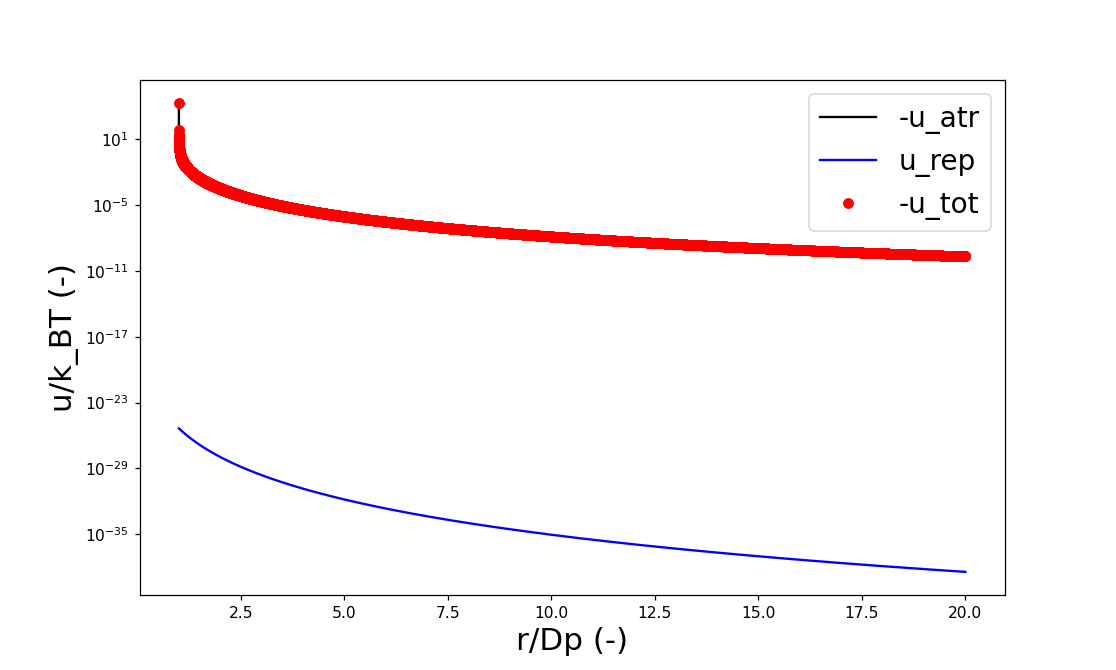

<IPython.core.display.Javascript object>


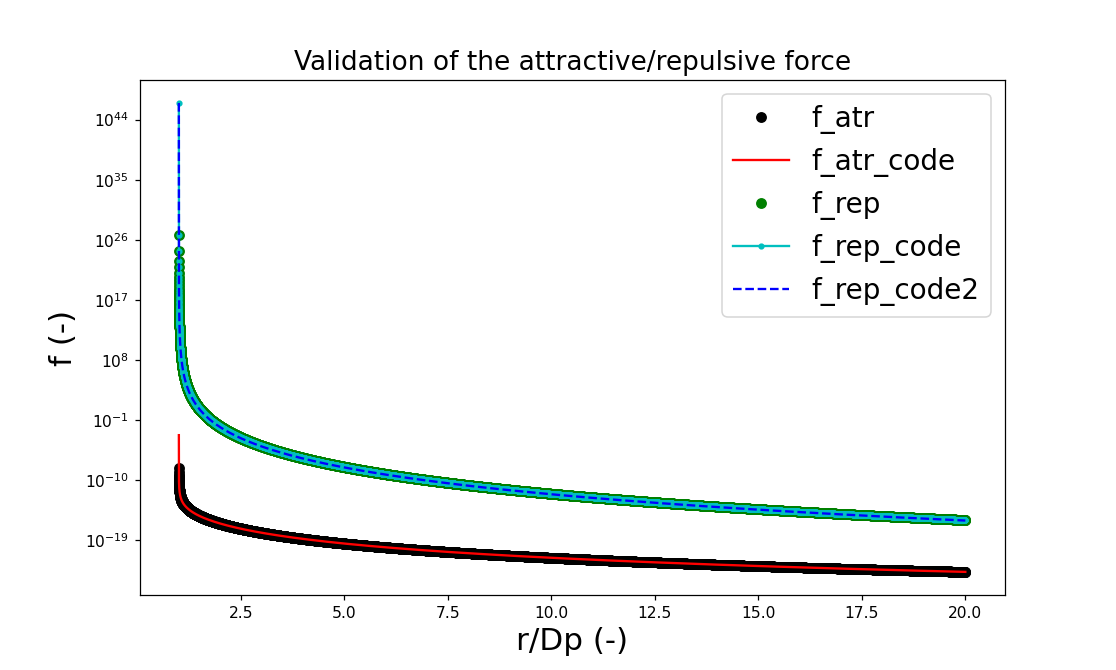

<IPython.core.display.Javascript object>


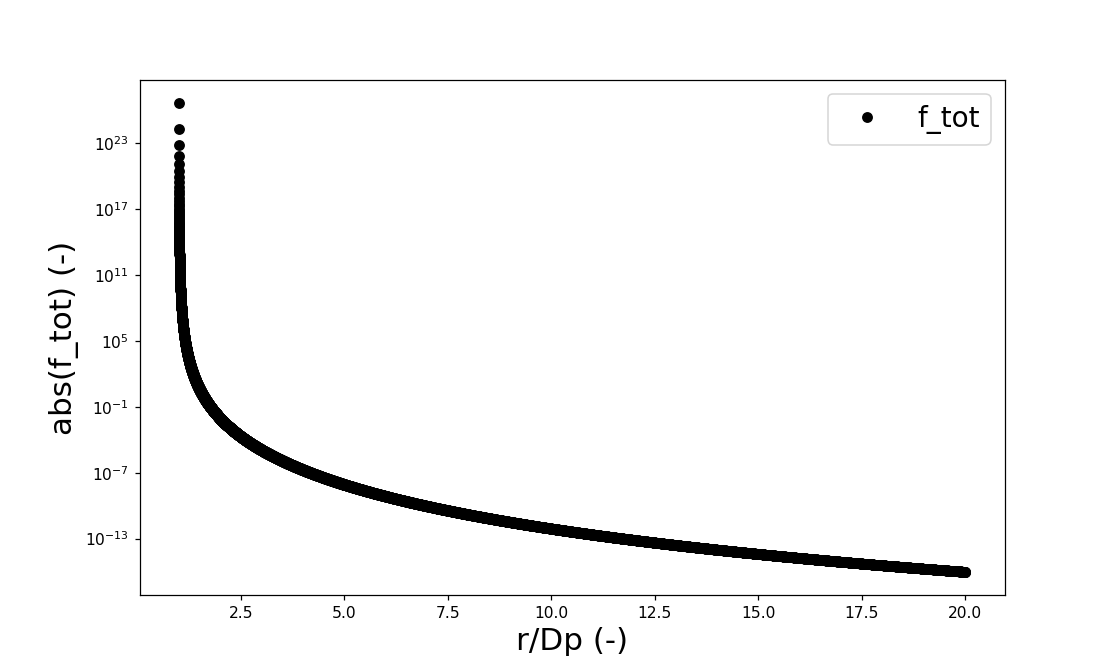

(<matplotlib.legend.Legend at 0x7f5114712610>, None)

In [12]:
def Determine_pot_well(Dpi,Dpj,A,sigma_lj,k_BT,points=10000):
    print("Dpi (nm): ",round(Dpi*1e+09), " Dpj (nm): ",round(Dpj*1e+09),
          " sigma_lj (nm): ", round(sigma_lj*1e+09,2), "\n  A (J): ",A," k_BT (J): ",k_BT)
    Dp = (Dpi+Dpj) * 0.5
    if(A==0):
        e_well = 0
        r_e_well = Dp
        return e_well,r_e_well
    radial_dist = np.logspace(np.log10(1),np.log10(20),points)*Dp*1.000001 #- Dp
    d = Dp+radial_dist
    # Interaction potentials
    u_atr = np.zeros_like(radial_dist)
    u_rep = np.zeros_like(radial_dist)
    u_tot = np.zeros_like(radial_dist)
    f_atr_code = np.zeros_like(radial_dist)
    f_rep_code = np.zeros_like(radial_dist)
    f_rep_code2 = np.zeros_like(radial_dist)
    f_atr = np.zeros_like(radial_dist)
    f_rep = np.zeros_like(radial_dist)
    f_tot = np.zeros_like(radial_dist)
    i=0
    s_LJ = sigma_lj/Dp
    for r in radial_dist:
        x = r/Dpi
        y = Dpi/Dpj
        u_atr[i] = ftp_support.Attractive_potential(x,y,A)
        u_rep[i] = ftp_support.Repulsive_potential(x,y,A,s_LJ)
        u_tot[i] = u_atr[i]+u_rep[i]
        # Compare with code
        f_atr_code[i] = -pyftp.Attr_interaction(r,0.5*Dpi,0.5*Dpj,A)
        f_rep_code[i] =  pyftp.Rep_interaction( r,0.5*Dpi,0.5*Dpj,A,s_LJ)
        #f_rep_code[i] =  Repulsive_interaction( r,0.5*Dpi,0.5*Dpj,A,s_LJ)
        f_rep_code2[i] = Repulsive_interaction2(r, Dpi, A,s_LJ)
        dr = 0.00001*r
        up = ftp_support.Attractive_potential((r+dr/2)/Dpi,y,A)
        um = ftp_support.Attractive_potential((r-dr/2)/Dpi,y,A)
        f_atr[i] = -(up-um)/dr
        up = Repulsive_potential2(0.5*Dpi, 0.5*Dpi, r+dr/2, A,s_LJ) #Repulsive_potential(Dpi, r+dr/2, A,s_LJ) #ftp_support.Repulsive_potential((r+dr/2)/Dpi,y,A,s_LJ)
        um = Repulsive_potential2(0.5*Dpi, 0.5*Dpi, r-dr/2, A,s_LJ) #Repulsive_potential(Dpi, r-dr/2, A,s_LJ) #ftp_support.Repulsive_potential((r-dr/2)/Dpi,y,A,s_LJ)
        f_rep[i] = -(up-um)/dr
        f_tot[i] = f_atr[i] - f_rep[i]
        i=i+1
    e_well = np.min(u_tot/k_BT)
    r_e_well = d[u_tot==np.min(u_tot)]
    print(e_well,r_e_well)
    return radial_dist,u_atr,u_rep,u_tot,f_atr,f_rep, f_tot,f_atr_code,f_rep_code,f_rep_code2

radial_dist, u_atr,u_rep,u_tot,f_atr,f_rep, f_tot,f_atr_code,f_rep_code,f_rep_code2 = Determine_pot_well(Dp,Dp,A[1],sigma_lj,k_BT)

fig, ax1 = plt.subplots(num=None, figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')
ax1.plot(radial_dist/Dp, -u_atr/k_BT,"-k",label="-u_atr")
ax1.plot(radial_dist/Dp, u_rep/k_BT,"-b",label="u_rep")
ax1.plot(radial_dist/Dp, -u_tot/k_BT,"o r",label="-u_tot")
#title = "$D_p=$"+str(round(Dp*1e+09,2))
#plt.title(title,fontsize=17); 
plt.yscale("log")
ax1.set_ylabel('u/k_BT (-)', fontsize=20)
ax1.set_xlabel('r/Dp (-)', fontsize=20)
plt.legend(fontsize=18, loc=0), plt.show()

fig, ax1 = plt.subplots(num=None, figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')
ax1.plot(radial_dist/Dp, -f_atr,"o k",label="f_atr")
ax1.plot(radial_dist/Dp, -f_atr_code,"-r",label="f_atr_code")
ax1.plot(radial_dist/Dp, f_rep,"o g",label="f_rep")
ax1.plot(radial_dist/Dp, f_rep_code,".-c",label="f_rep_code")
ax1.plot(radial_dist/Dp, f_rep_code2,"--b",label="f_rep_code2")
title = "Validation of the attractive/repulsive force"
plt.title(title,fontsize=17);
plt.yscale("log")
ax1.set_ylabel('f (-)', fontsize=20)
ax1.set_xlabel('r/Dp (-)', fontsize=20)
plt.legend(fontsize=18, loc=0), plt.show()

fig, ax1 = plt.subplots(num=None, figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')
ax1.plot(radial_dist/Dp, np.abs(f_tot),"o k",label="f_tot")
plt.yscale("log")
ax1.set_ylabel('abs(f_tot) (-)', fontsize=20)
ax1.set_xlabel('r/Dp (-)', fontsize=20)
plt.legend(fontsize=18, loc=0), plt.show()

In [13]:
# Potential well analysis
e_well_i = np.zeros_like(A)
r_e_well_i = np.zeros_like(A)
factor_vdw_i = np.zeros_like(A)

for i in range(len(A)):
    e_well,r_e_well = ftp_support.Determine_pot_well(Dp,Dp,A[i],sigma_lj,k_BT)
    e_well_i[i] = e_well
    r_e_well_i[i] = r_e_well
    factor_vdw_i[i] = r_e_well/(0.5*(Dp+Dp))

<IPython.core.display.Javascript object>


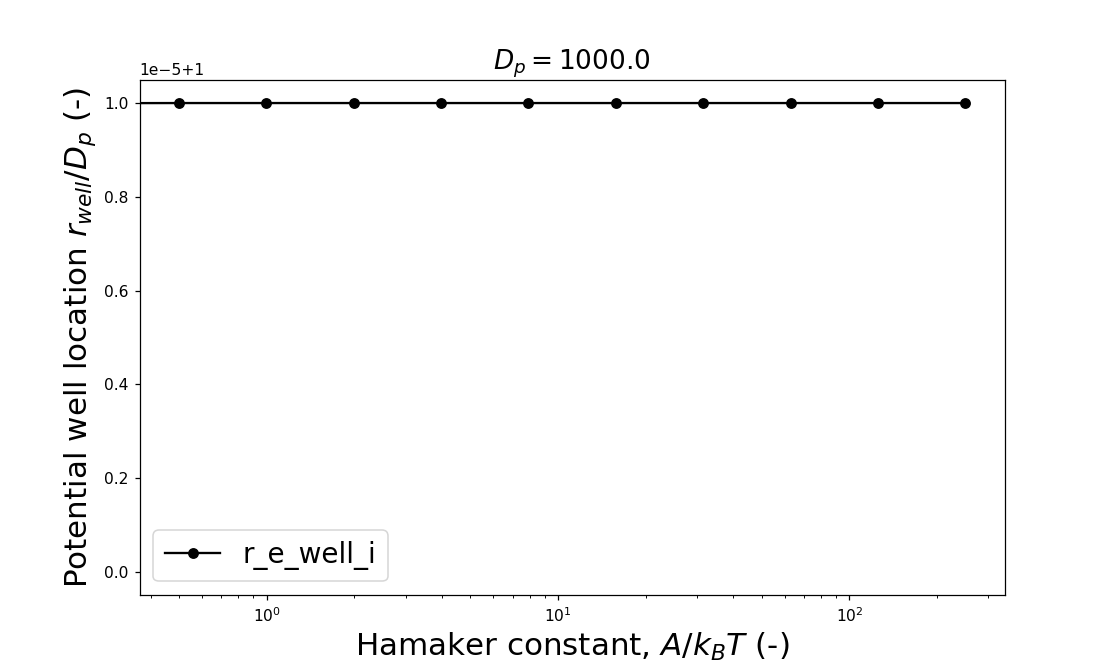

<IPython.core.display.Javascript object>


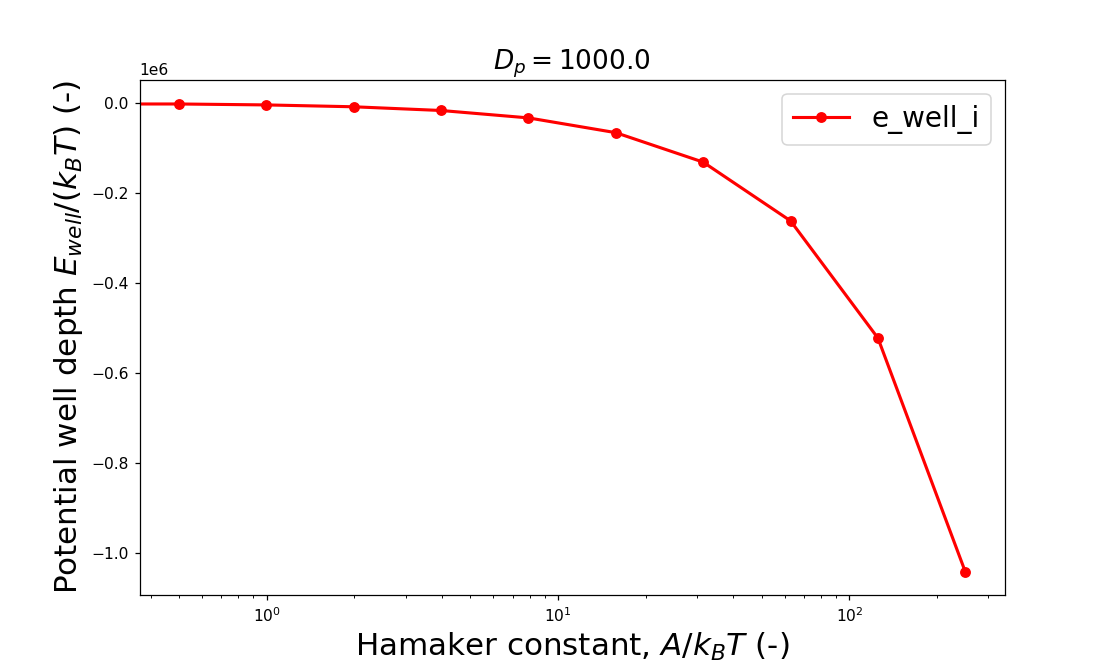

(<matplotlib.legend.Legend at 0x7f51145e6a30>, None)

In [14]:
fig, ax1 = plt.subplots(num=None, figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')
ax1.plot(A/k_BT,r_e_well_i/Dp,"o-k",label="r_e_well_i")
title = "$D_p=$"+str(round(Dp*1e+09,2))
plt.title(title,fontsize=17); plt.xscale("log")
ax1.set_ylabel('Potential well location $r_{well}/D_p$ (-)', fontsize=20)
ax1.set_xlabel('Hamaker constant, $A/k_BT$ (-)', fontsize=20)
plt.legend(fontsize=18, loc=0), plt.show()

fig, ax1 = plt.subplots(num=None, figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')
ax1.plot(A/k_BT,e_well_i,"o-r", linewidth=2,label="e_well_i")
#ax1.plot(Dp*1e+09,r_e_well_i/Dp,".-k",label="r_e_well_i")
plt.title(title,fontsize=17); plt.xscale("log")
ax1.set_ylabel('Potential well depth $E_{well}/(k_BT)$ (-)', fontsize=20)
ax1.set_xlabel('Hamaker constant, $A/k_BT$ (-)', fontsize=20)
plt.legend(fontsize=18, loc=0), plt.show()

In [15]:
# Read Ouyang results
ouyang_res = pd.read_csv('old_results/Ouyang_res.dat', sep='\t')
ouyang_res.head()

A/(k_b*T)    n_C   n_FM
0        0.5  1.039  1.274
1        1.5  1.075  1.434
2        2.5  1.100  1.535
3        3.5  1.119  1.612
4        4.5  1.136  1.676

In [16]:
import os

def Open_FTP_results(path):
    # DMA HV renamed as V1
    cols = ["Kn_d_j","H","ftp_times_j","ftp_times_std_j",
            "tau_12_j","Kn_g_j","L_j","Rc_j","V_box","t_ij",
            "A_j_k_BT","f_12_j","beta_j"]
    data = pd.read_csv(path,delimiter=',', names=cols)
    return data

def Open_FTP_recursively(direct):
    files = os.listdir(direct)
    files.sort()
    # Open spheres:
    simulations_co = Open_FTP_results(direct+files[0])
    for i in range(1,len(files)):
        new_simulations_co = Open_FTP_results(direct+files[i])
        simulations_co = pd.concat([simulations_co, new_simulations_co])
    simulations_co = simulations_co.groupby(by=["A_j_k_BT"]).agg((np.mean))
    simulations_co = simulations_co.reset_index()
    return simulations_co

In [17]:
file_name = "RES_out/validation_spheres_with_vdw_ballistic.dat"
simulations_fm = pd.read_csv(file_name, sep=",",
                            names=["Kn_d_j","H","ftp_times_j","ftp_times_std_j",
                                     "tau_12_j","Kn_g_j","L_j","Rc_j","V_box","t_ij",
                                     "A_j_k_BT"])
#file_name = "RES_out/validation_spheres_with_vdw_diffusive.dat"
#simulations_co = pd.read_csv(file_name, sep=",",
#                            names=["Kn_d_j","H","ftp_times_j","ftp_times_std_j",
#                                     "tau_12_j","Kn_g_j","L_j","Rc_j","V_box","t_ij",
#                                     "A_j_k_BT","f_12_j","beta_j"])

In [18]:
simulations_co = Open_FTP_recursively("RES_out/validation_spheres_with_vdw_diffusive_NoRep/")
simulations_co

FileNotFoundError: [Errno 2] No such file or directory: 'RES_out/validation_spheres_with_vdw_diffusive_NoRep/'

In [ ]:
def vdW_sphere_sphere(a1,a2,d, A):
    """
    Determines Hamaker vdW interaction
    energy between two spheres

        Parameters
        ----------
        ai : float
            Radius of the i'th sphere
        d : float
            Distance between centers of both
            spheres
        A : float
            Hamaker's constant
        
        Returns
        -------
        u_vdw: float
            The total interaction energy between
            both spheres
    """
    U_atr1 = 2*a1*a2/(d**2-(a1+a2)**2)
    U_atr2 = 2*a1*a2/(d**2-(a1-a2)**2)
    U_atr3 = np.log((d**2-(a1+a2)**2)/(d**2-(a1-a2)**2))
    U_vdw = -(A/6)*(U_atr1 + U_atr2 + U_atr3)
    return float(U_vdw)

def ev_dE_dr(r,a,A):
    E1 = vdW_sphere_sphere(a,a,r, A)
    dr = 0.00000001 * r
    E2 = vdW_sphere_sphere(a,a,r+dr, A)
    return (E2-E1)/dr

def ev_dE2_dr2(r,a,A):
    dr = 0.00000001 * r
    E1 = vdW_sphere_sphere(a,a,r+dr, A)
    E = vdW_sphere_sphere(a,a,r, A)
    E2 = vdW_sphere_sphere(a,a,r-dr, A)
    return (E1 -2*E + E2)/(dr**2)

def Alam_FM(r,a,A,k_BT):
    dE_dr = ev_dE_dr(r,a,A)
    dE2_dr2 = ev_dE2_dr2(r,a,A)
    E = vdW_sphere_sphere(a,a,r, A)
    e_xp = np.exp(-1/(k_BT)*(dE_dr * r/2+E))
    return (dE_dr * r*dE2_dr2)*e_xp * r**2

def Alam_FM2(x,A,k_BT):
    temp0 = ((4*x**5-3*x**3)/(1-4*x**2)**3)
    temp1 = np.exp(-A/(3*k_BT) * ((12*x**4-2*x**2)/((1-4*x**2)**2)))
    return temp0 * temp1

def fun_co(x,A,k_BT):
    return (2+(13/10)*np.sqrt(x/(2*(1-2*x)))+x/(2-4*x))*np.exp((-A/3/k_BT)*(((2*x**2-4*x**4)/(1-4*x**2))+0.5*np.log(1-4*x**2)))
    #return (2+(13/10)*np.sqrt(x/(2*(1-2*x)))+x/(2-4*x))*np.exp((-A/6/k_BT)*(((4*x**2-8*x**4)/(1-4*x**2))+np.log(1-4*x**2)));
def fun_fm(x,A,k_BT): 
    return -((4*x**5-3*x**3)/((1-4*x**2)**3))*np.exp((-A/3/k_BT)*(((12*x**4-2*x**2)/((1-4*x**2)**2))-0.5*np.log(1-4*x**2)));

from scipy.integrate import quad

eta_alam_fm = np.zeros_like(A)
eta_alam_co = np.zeros_like(A)
for i in range(len(A)):
    Ai = A[i]
    I_fm = quad(fun_fm, 0, 0.5, args=(Ai,k_BT))[0]
    I_co = quad(fun_co, 0, 0.5, args=(Ai,k_BT))[0]
    eta_alam_fm[i] = (I_fm*(8*Ai/(3*k_BT)))
    eta_alam_co[i] = np.power(I_co,-1)

In [ ]:
fig, ax1 = plt.subplots(num=None, figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')
ax1.plot(A/k_BT,eta_alam_fm,"--g", linewidth=2,label="Alam, 1987")
ax1.plot(ouyang_res["A/(k_b*T)"],ouyang_res["n_FM"],"-r", linewidth=2,label="Ouyang et al. 2012")
ax1.plot(simulations_fm["A_j_k_BT"],simulations_fm["H"]/simulations_fm["H"].iloc[0],"o b",label="Simulated")
title = "$Kn_d=$"+str(round(simulations_fm["Kn_d_j"].iloc[0],2))
plt.title(title,fontsize=17)
plt.xscale("log")
#plt.ylim([0,np.max(ouyang_res["n_FM"])])
ax1.set_xlabel('Hamaker constant, $A/(k_BT)$ (-)', fontsize=20)
ax1.set_ylabel('Coagulation enhancement $\eta_{FM}$ (-)', fontsize=20)
plt.legend(fontsize=18, loc=0), plt.show()
plt.savefig("RES_out/Kernels_ballistic_comp_Alam.png")

In [ ]:
def Attractive_potential(r,a,b, A):
    f0 = -A/6
    f1 = 2*a*b/(r**2-(a+b)**2)
    f2 = 2*a*b/(r**2-(a-b)**2)
    f3 = np.log((r**2-(a+b)**2)/(r**2-(a-b)**2))
    return f0*(f1+f2+f3)

In [ ]:
def Fuchs_co(r,A,k_BT,Dpi,Dpj):
    x = r/Dpi
    y = Dpi/Dpj
    if (x>100):
        W = 0
    else:
        a=0.5*Dpi
        b=0.5*Dpj
        W = Attractive_potential(r,a,b, A)
        #W = ftp_support.Attractive_potential(x,y, A)
    f = np.exp(W/k_BT) * np.power(r,-2)
    return f

def Fuchs_co2(r,A,k_BT,Dpi,Dpj):
    R = 0.5*(Dpi+Dpj)/r
    x = R/Dpi
    y = Dpi/Dpj
    W = ftp_support.Attractive_potential(x,y, A)
    f = np.exp(W/k_BT)
    return f

eta_Fuchs_co = np.zeros_like(A)
eta_Fuchs_co2 = np.zeros_like(A)
for i in range(len(A)):
    Ai = A[i]
    Dp_lim = Dp * 1000
    I_co = quad(Fuchs_co, Dp, Dp_lim, args=(Ai,k_BT,Dp,Dp))[0]
    I_co += 1/Dp_lim
    eta_Fuchs_co[i] = np.power(Dp*I_co,-1)
    I_co = quad(Fuchs_co2, 0, 1, args=(Ai,k_BT,Dp,Dp))[0]
    eta_Fuchs_co2[i] = np.power(I_co,-1)

In [ ]:
r = np.logspace(0,2,100) * Dp
W = np.zeros_like(r)
W1 = np.zeros_like(r)

for i in range(len(r)):
    x = r[i]/Dp
    y = 1
    a=b=0.5*Dp
    W[i] = Attractive_potential(r[i],a,b, A[1])
    W1[i] = ftp_support.Attractive_potential(x,y, A[1])

fig, ax1 = plt.subplots(num=None, figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')
ax1.plot(r/Dp,-W/k_BT, "o-g", linewidth=2,label="W/k_BT")
ax1.plot(r/Dp,-W1/k_BT, "--k", linewidth=2,label="W_1/k_BT")
plt.yscale("log")
#plt.ylim([0.8,np.max(ouyang_res["n_C"])])
ax1.set_xlabel('r/Dp (-)', fontsize=20)
ax1.set_ylabel('W/$k_B$T (-)', fontsize=20)
plt.legend(fontsize=18, loc=0), plt.show()

In [ ]:
simulations_co["eta"] = simulations_co["beta_j"]/simulations_co["beta_j"].iloc[0]
simulations_co

In [ ]:
def Ouyang_eq_co(A,k_BT):
    A_dimensionless = A/k_BT
    if (A_dimensionless < 4.5):
        eta = 1 + 0.0586*np.power(A_dimensionless, 0.5704)
    else:
        eta = 1/(0.9976 + - 0.0725 * np.log(A_dimensionless))
    return eta

Ouyang_cont2 = np.zeros_like(A)

for i in range(len(A)):
    Ouyang_cont2[i] = Ouyang_eq_co(A[i],k_BT)

In [ ]:
fig, ax1 = plt.subplots(num=None, figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')
ax1.plot(A/k_BT,eta_alam_co,"--g", linewidth=2,label="Alam, 1987")
ax1.plot(A/k_BT,eta_Fuchs_co,"o-", color="orange", linewidth=2,label="Fuchs, 1964")
#ax1.plot(A/k_BT,eta_Fuchs_co2,"--", color="cyan", linewidth=2,label="Fuchs")
#ax1.plot(ouyang_res["A/(k_b*T)"],ouyang_res["n_C"],"-r", linewidth=2,label="Ouyang et al. 2012")
ax1.plot(A/k_BT,Ouyang_cont2,"--k", linewidth=2,label="Ouyang et al. 2012")
ax1.plot(simulations_co["A_j_k_BT"],simulations_co["beta_j"]/simulations_co["beta_j"].iloc[0],"o b",label="Simulated")
title = "$Kn_d=$"+str(round(simulations_co["Kn_d_j"].iloc[0],2))
plt.title(title,fontsize=17)
plt.xscale("log")
plt.ylim([0.4,np.max(ouyang_res["n_C"])])
ax1.set_xlabel('Hamaker constant, $A/(k_BT)$ (-)', fontsize=20)
ax1.set_ylabel('Coagulation enhancement $\eta_{C}$ (-)', fontsize=20)
plt.legend(fontsize=18, loc=0), plt.show()
plt.savefig("RES_out/Kernels_diffusive_comp_Fuchs.png")